In [2]:
import matplotlib.pyplot as plt
import pytesseract
import cv2
import numpy as np
import math
from PIL import Image
EDGE_THRES = 300
custom_config = r'--oem 3 --psm 6'

# code

In [40]:
def get_color(box):
        temp = box.copy()
        shape = temp.shape
        temp = np.reshape(temp,(temp.shape[0]*temp.shape[1],shape[2]))
        colors,count = np.unique(temp,axis=0,return_counts=True)
        idx = np.argmax(count)
        color1 =  colors[idx]
        count[idx] = -1
        idx = np.argmax(count)
        color2 =  colors[idx]
        if(not np.array_equal(color1,(0,0,0))):
                return color1
        return color2


In [61]:
image = cv2.imread("../data/outs/detected_box.png")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
color1 = get_color(image[25:140,935:1150])
print(color1)
color = np.zeros((50,50,3),dtype=np.uint8)
color[:,:,0] = color1[0]
color[:,:,1] = color1[1]
color[:,:,2] = color1[2]

plt.figure(figsize=(5,5))
plt.imshow(color)
# plt.figure(figsize=(10,10))
# plt.imshow(image[25:140,935:1150])


[255 153 255]


# Hough

In [11]:
def multiply_kernel(kernel,image):
    if(np.shape(kernel) != np.shape(image)): return image
    a,b = np.shape(kernel)
    kernel = kernel.reshape(a*b)
    image = image.reshape(a*b)

    output = np.dot(kernel,image)
    
    kernel = kernel.reshape(a,b)
    image = image.reshape(a,b)
    return output

In [12]:
def edge_detection(image,thres):
    kernelx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    kernely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    img = image.copy()
    [x,y] = np.shape(img)
    G_x = np.zeros(np.shape(img))
    G_y = np.zeros(np.shape(img))
    output = np.zeros(np.shape(img))
    k,k1 = np.shape(kernelx)
    
    img = np.pad(img,math.floor(k/2))
    
    for (i,j),val in np.ndenumerate(G_x):
        G_x[i,j] = multiply_kernel(kernelx,img[i:i+k,j:j+k]) 
        G_y[i,j] = multiply_kernel(kernely,img[i:i+k,j:j+k])
        output[i,j] = math.sqrt(G_x[i,j]**2 + G_y[i,j]**2)
    
    G_x = (np.round(G_x)).astype(int)
    G_y = (np.round(G_y)).astype(int)
    output = (np.round(output)).astype(int)
    where1 = np.where(output >= thres)
    where0 = np.where(output<thres)
    output[where1] = 255
    output[where0] = 0

    return G_x,G_y,output
    

In [21]:
def get_coords(angle,dist,shape):
    coords = []
    
    # j = 0
    if((dist/math.sin(angle)) >=0 and (dist/math.sin(angle))<shape[0]):
        coords.append((int(0),int(dist/math.sin(angle))))
    
    # i = 0
    if((dist/math.cos(angle)) >=0 and (dist/math.cos(angle)<shape[1])):
        coords.append((int(dist/math.cos(angle)),int(0)))
    
    # i = shape[0]
    if(((dist-shape[0]*math.sin(angle))/math.cos(angle)) >=0 and ((dist-shape[0]*math.sin(angle))/math.cos(angle)<shape[1])):
        coords.append((int((dist-shape[0]*math.sin(angle))/math.cos(angle)),int(shape[0])))
    
    # j = shape[1]
    if(((dist-shape[1]*math.cos(angle))/math.sin(angle)) >=0 and ((dist-shape[1]*math.cos(angle))/math.sin(angle)<shape[0])):
        coords.append((int(shape[1]),int((dist-shape[1]*math.cos(angle))/math.sin(angle))))
    
    return list(set(coords))


In [192]:
def hough(image,thres2):
    img = image.copy()
    out = image.copy()
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    size = np.shape(img)

    G_x, G_y,edge = edge_detection(img,thres2)
    angle = np.arctan2(G_y,G_x)
    length = int(np.ceil(math.sqrt(size[0]**2 + size[1]**2)))
    
    dist = np.linspace(-length,length,length+1)
    len_dist = len(dist)
    ang = np.linspace(0,180,181)
    sin = np.sin(np.deg2rad(ang))
    cos = np.cos(np.deg2rad(ang))
    len_ang = len(ang)
    param = np.zeros((len_dist,len_ang))
    param_sapce = np.zeros(size)
    
    for (i,j),val in np.ndenumerate(edge):
        for k in range(len_ang):
            if(val ==255):
                p = int((j*cos[k] + i*sin[k]))
                param_sapce[i,j] = p
                x = np.where(dist == p)
                param[x,k] = param[x,k] + 1
    
    return param,len_dist,dist

def findlines(image,accum,len_dist,dist,thres):
    size = image.shape
    out = image.copy()
    coordinates = []

    ang = np.linspace(0,180,181)
    len_ang = len(ang)
    for i in range(len_dist):
        for j in range(len_ang):
            if(accum[i,j] >= thres):
                if(dist[i] == 0): continue
                # print(ang[j],dist[i])
                coordinates.append((ang[j],dist[i]))
                coords = get_coords(np.deg2rad(ang[j]),dist[i],size)
                # print(coords)
                if(len(coords)>=2):
                    out = cv2.line(out,coords[1],coords[0],(0,255,0),1)

    
    return out,coordinates


# Rotation

In [105]:
def dims(len_x,len_y,angles):
    if(angles > math.pi/2):
        angle = angles - math.pi/2
    else:
        angle = angles
    a = int(len_x/2)
    b = int(len_y/2)
    
    xa = int(-a*math.cos(angle) + b*math.sin(angle)) 
    ya = int(-a*math.sin(angle) - b*math.cos(angle))

    xb = int(-a*math.cos(angle) - b*math.sin(angle)) 
    yb = int(-a*math.sin(angle) + b*math.cos(angle))

    xc = int(a*math.cos(angle) - b*math.sin(angle)) 
    yc = int(a*math.sin(angle) + b*math.cos(angle))

    xd = int(a*math.cos(angle) + b*math.sin(angle)) 
    yd = int(a*math.sin(angle) - b*math.cos(angle))
    
    
    # print(a,b)
    # print(xa,ya)
    # print(xb,yb)
    # print(xc,yc)
    # print(xd,yd)
    if(angles > math.pi/2): return (abs(yc-ya),abs(xd-xb))
    return (abs(xd-xb),abs(yc-ya))

In [106]:
def interpolation(x,y,img):
    size = np.shape(img)
    sum = 0
    flag = 0
    ceil_x = int(np.ceil(x) + size[0]/2)
    floor_x = int(np.floor(x) + size[0]/2)
    ceil_y = int(np.ceil(y) + size[1]/2)
    floor_y = int(np.floor(y) + size[1]/2)
    i = 0
    if(ceil_x < size[0] and ceil_y < size[1] and ceil_x  >= 0 and ceil_y >= 0 ):
        sum = sum + img[ceil_x,ceil_y]
        flag = 1
        i = i+1
    if(ceil_x < size[0] and floor_y < size[1] and ceil_x  >= 0 and floor_y >= 0 ):
        sum = sum + img[ceil_x,floor_y]
        flag = 1
        i = i+1
    if(floor_x < size[0] and ceil_y < size[1] and floor_x  >= 0 and ceil_y >= 0 ):
        sum = sum + img[floor_x,ceil_y]
        flag = 1
        i = i+1
    if(floor_x < size[0] and floor_y < size[1] and floor_x  >= 0 and floor_y >= 0 ):
        sum = sum + img[floor_x,floor_y]
        flag = 1
        i = i+1
    if(flag == 0):
        return(255)
    else:
        return(int(sum)/i)

In [107]:
def imrotate_g(image,angle,retainAllPixels):
    angle = np.deg2rad(angle)
    img = image.copy()
    size = np.shape(img)
    if(retainAllPixels):
        size_up = dims(size[0],size[1],abs(angle))
        output = np.zeros((size_up[0]+2,size_up[1]+2),dtype=np.uint8)
        for i in range(size_up[0]+2):
            for j in range(size_up[1]+2):
                a = (i-int(size_up[0]/2))
                b = (j-int(size_up[1]/2))
                x = a*math.cos(-angle) - b*math.sin(-angle)
                y = a*math.sin(-angle) + b*math.cos(-angle) 
                output[i,j]  = interpolation(x,y,img)
        
    else:
        output = np.zeros(size,dtype=np.uint8)
        for i in range(size[0]):
            for j in range(size[1]):
                a = (i-int(size[0]/2))
                b = (j-int(size[1]/2))
                x = (a*math.cos(-angle) - b*math.sin(-angle)) 
                y = (a*math.sin(-angle) + b*math.cos(-angle))
                output[i,j]  = interpolation(x,y,img)
    
    return output


In [190]:
def imrotate(image,angle,retainAllPixels=False):
    if(angle == 0):
        return image

    output_r = imrotate_g(image[:,:,0],angle,retainAllPixels)
    output_g = imrotate_g(image[:,:,1],angle,retainAllPixels)
    output_b = imrotate_g(image[:,:,2],angle,retainAllPixels)
    output = np.zeros((np.shape(output_r)[0],np.shape(output_r)[1],3),dtype=np.uint8)
    output[:,:,0] = output_r
    output[:,:,1] = output_g
    output[:,:,2] = output_b

    return output

# Funcs

In [265]:
def cor_rot(accum,image,location,len_dist,dist):
    x = np.where(dist == 0)
    accum[x[0],:] = 0
    max_val = np.max(accum)
    output,coords = findlines(image,accum,len_dist,dist,max_val)
    angle = coords[0][0] - 90
    temp = Image.open(location)
    rotated = temp.rotate(angle,resample=Image.Resampling.BICUBIC)
    rotated = rotated.save("../data/inputs/temp/inter.png")
    correct_image = cv2.imread("../data/inputs/temp/inter.png")
    correct_image = cv2.cvtColor(correct_image,cv2.COLOR_BGR2RGB)
    where = np.where(correct_image == (255,255,255))
    x1 = np.min(where[0])
    x2 = np.max(where[0])
    y1 = np.min(where[1])
    y2 = np.max(where[1])
    correct_image = correct_image[x1:x2,y1:y2]  
    return correct_image


In [305]:
def get_middle_box(image,accum,len_dist,dist):
    flat_accum = accum.flatten()
    flat_accum.sort()
    thres = flat_accum[-15]
    output,coords = findlines(image,accum,len_dist,dist,thres)
    i = 0
    j = 0
    lens = len(coords)
    while j < lens-1:
        if(coords[i+1][1] - coords[i][1] < 5):
            temp1 = (coords[i+1][0]+coords[i][0])/2
            temp2 = (coords[i+1][1]+coords[i][1])/2
            coords.remove(coords[i+1])
            coords.remove(coords[i])
            coords.insert(i,(temp1,temp2))
            j+=1
        else:
            i+=1
            j+=1

    idx = int(coords[0][1])
    idx2 = int(coords[1][1])
    plt.imshow(image[idx:idx2])
    text = pytesseract.image_to_string(image[idx:idx2], config=custom_config)
    print(text)
    text = str.lower(text)
    sem = ""
    if "monsoon" in text:
        sem = "Monsoon"
    if "spring" in text:
        sem = "Spring"
    year = [int(i) for i in text.split() if i.isdigit()]
    
    temp1 = 0
    max = 0
    for i in range(len(coords) -1):
        temp = coords[i+1][1] - coords[i][1]
        if(temp > max):
            # print(temp,i)
            max = temp
            temp1 = i
    # print(temp1)
    ll = int(coords[temp1][1])
    ul = int(coords[temp1+1][1])

    box = image[ll-5:ul+5]
    return box,sem,year

# Testing

## Input of the image

In [194]:
image = cv2.imread("A-S23.png")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_bw = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

In [245]:
image = Image.open("mjp.jpg")
angle = 20
rotated = image.rotate(angle,expand=True,resample=Image.Resampling.BICUBIC)
rotated = rotated.save("../data/inputs/rotated.png")

## Rotate Image for Testing 

In [246]:
# image_rot = imrotate(image,10,True)
# plt.imshow(image_rot)
LOC = "../data/inputs/rotated.png"
image_rot = cv2.imread(LOC)
image_rot = cv2.cvtColor(image_rot,cv2.COLOR_BGR2RGB)
accum_rot,len_dist_rot,dist_rot = hough(image_rot,EDGE_THRES)

## Correction of Rotated image

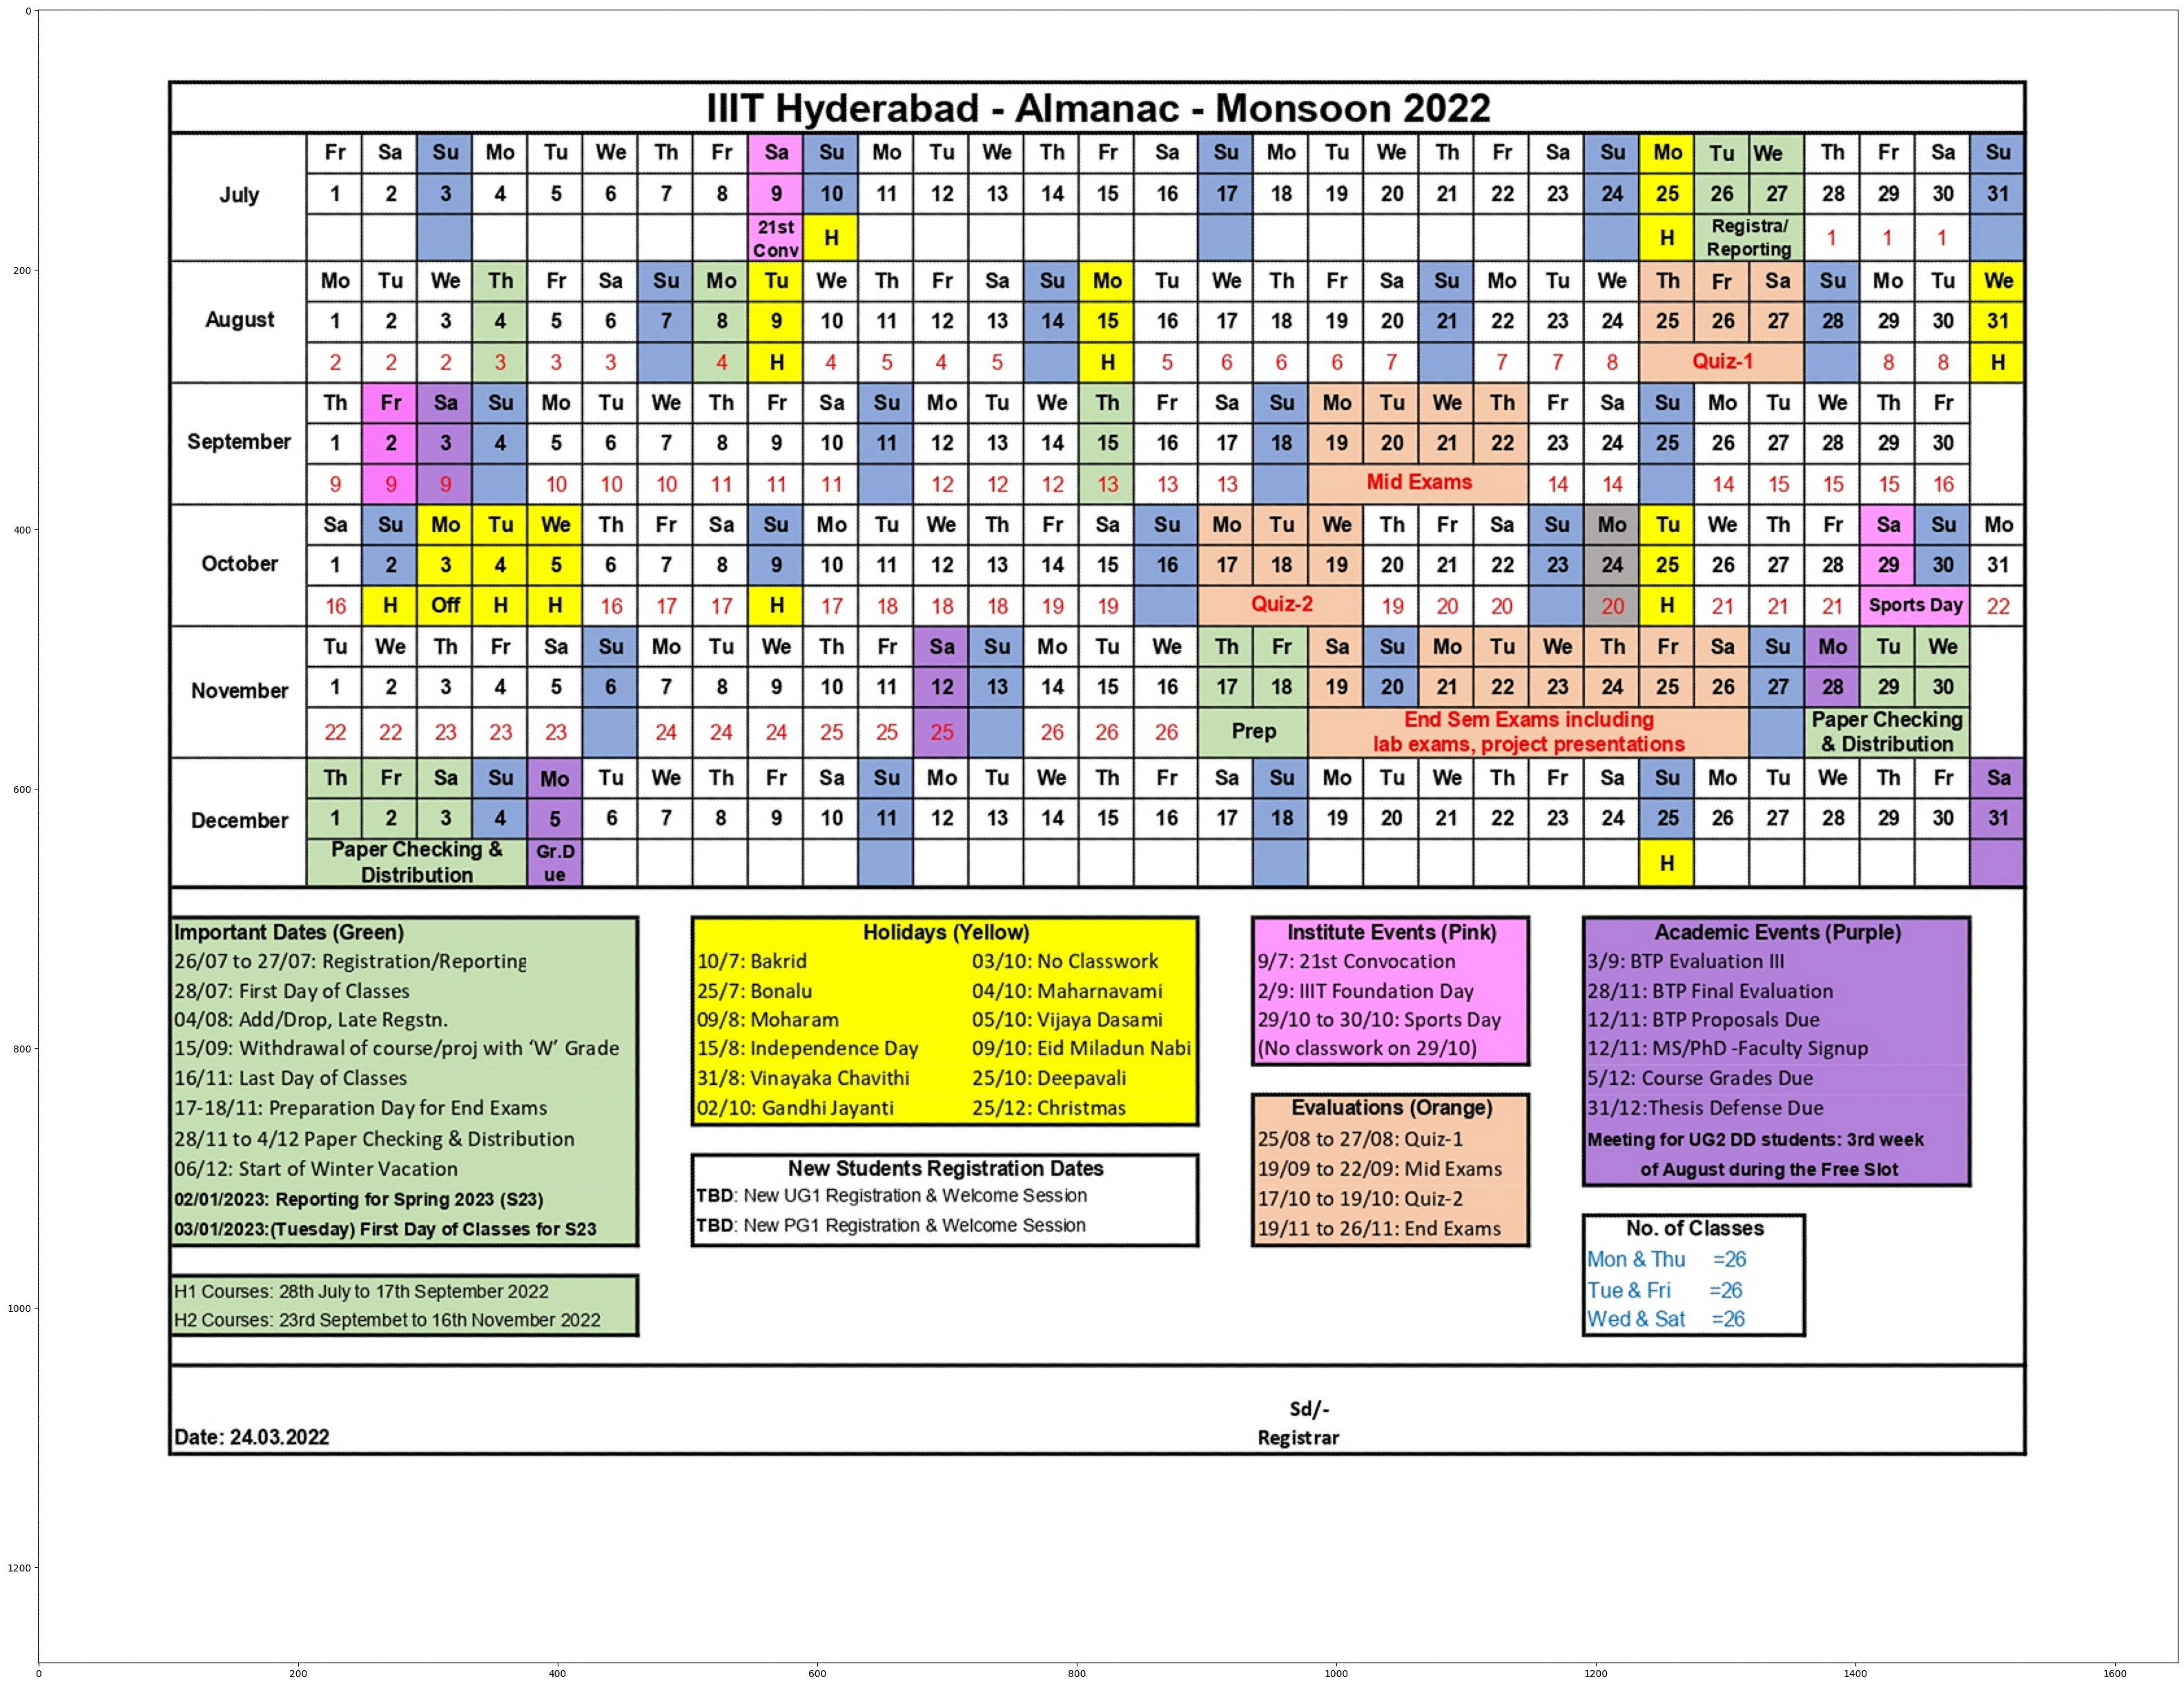

In [266]:
corrected_image = cor_rot(accum_rot,image_rot,LOC,len_dist_rot,dist_rot)
plt.figure(figsize=(40,40))
plt.imshow(corrected_image)

## Find Hough of the corrected image

In [267]:
accum,len_dist,dist = hough(corrected_image,EDGE_THRES)

## Getting the interested Box

IIIT Hyderabad - Almanac - Monsoon 2022

Monsoon [2022]


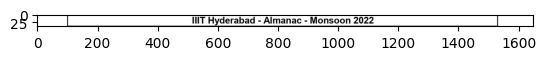

In [306]:
box,sem,year = get_middle_box(corrected_image,accum,len_dist,dist)
plt.figure(figsize=(40,40))
plt.imshow(box)
print(sem,year)

In [300]:
box = cv2.cvtColor(box,cv2.COLOR_RGB2BGR)
cv2.imwrite("../data/outs/detected_box.png",box)

True